<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/notebook/Lab06_SimpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
     

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [4]:
path_train = '/content/drive/data/xray/covid19/train/'
path_valid = '/content/drive/data/xray/covid19/valid/'

## 영상데이터에 대한 전처리과정 정의하기

In [5]:
train_transforms = transforms.Compose(
      [
          transforms.Grayscale(num_output_channels=1),
          transforms.Resize((64,64)),
          transforms.ToTensor(),
      ]
    )

## ImageFolder를 활용하여 data loader를 생성하기

In [6]:
batch_size = 32

trainset = torchvision.datasets.ImageFolder(root = path_train,transform=train_transforms)
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=train_transforms)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=False)

In [7]:
tgtnames = trainset.classes
print(tgtnames)

['covid19', 'normal', 'opacity']


torch.Size([32, 1, 64, 64])
torch.Size([32])


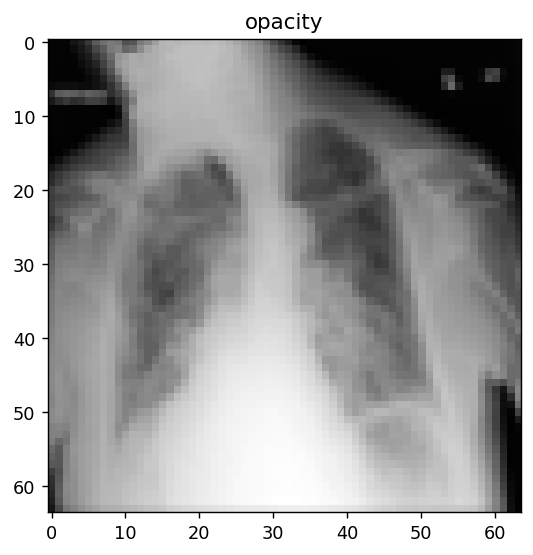

In [9]:
for X, y in trainloader:
  print(X.shape)
  print(y.shape)
  I = X[0][0].numpy()
  plt.figure(dpi=128)
  plt.imshow(I,cmap='gray')
  plt.title(tgtnames[y[0]])
  plt.show()
  break

## CNN model을 정의해보기

In [14]:
mycnn = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=6*32*32, out_features=120),
    nn.ReLU(),
    nn.Linear(120, 3),
)
mycnn = mycnn.to(device)
print(mycnn)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=6144, out_features=120, bias=True)
  (5): ReLU()
  (6): Linear(in_features=120, out_features=3, bias=True)
)


## Hyperparameter의 설정

In [15]:
# setting hyper-parameters
learning_rate = .1
num_epochs = 30

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(mycnn.parameters(),lr=learning_rate) # sgd

## Model 학습 진행

In [16]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
    i=0
    l_epoch = 0
    correct = 0
    mycnn.train()
    for X,y in trainloader:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat=mycnn(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    mycnn.eval()
    for X,y in validloader:
        X,y = X.to(device),y.to(device)
        y_hat = mycnn(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))

    plt.figure(2,dpi=80)
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='upper left')
    plt.title('epoch: %d '%(epoch))
    plt.savefig('loss_curve.png')
#        plt.show()
    plt.close(2)

    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])

epoch: 0 
train loss:  1.0647422388980263
train accuracy:  0.4466666579246521
valid accuracy:  0.4466666579246521
epoch: 5 
train loss:  0.7994950445074784
train accuracy:  0.6583333611488342
valid accuracy:  0.6333333253860474
epoch: 10 
train loss:  0.6871462872153834
train accuracy:  0.7016666531562805
valid accuracy:  0.70333331823349
epoch: 15 
train loss:  0.62472192864669
train accuracy:  0.7441666722297668
valid accuracy:  0.7200000286102295
epoch: 20 
train loss:  0.5148573925620631
train accuracy:  0.7875000238418579
valid accuracy:  0.6566666960716248
epoch: 25 
train loss:  0.4458579013222142
train accuracy:  0.8183333277702332
valid accuracy:  0.7666666507720947


## 학습과정의 요약

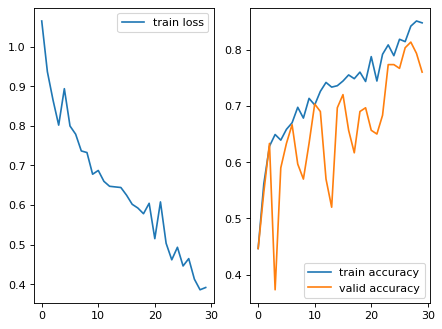

In [18]:
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()
     

## Validation set에 대한 개별결과 확인 (Inference)

In [41]:
from PIL import Image

In [42]:
N = 42
validset.imgs[N][0]

'/content/drive/MyDrive/class/BMEAI/data/xray/covid19/valid/covid19/covid_549.png'

covid19


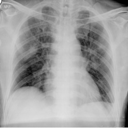

In [43]:
I = Image.open(validset.imgs[N][0])
X = train_transforms(I)
y = validset.targets[N]

print(tgtnames[y])
I


In [52]:
y_hat = mycnn(X.unsqueeze(1).to(device))
print(y_hat.cpu().detach().numpy())
y_hat = y_hat.argmax(dim=1)
print(f'prediction of mycnn: {tgtnames[y_hat.cpu().numpy()[0]]}')

[[ 7.4568396 -1.4722638 -5.913241 ]]
prediction of mycnn: covid19


## Validation set에 대한 결과 요약하기

In [57]:
y_list = np.array([])
y_hat_list = np.array([])
for X,y in validloader:
  y_hat = mycnn(X.to(device))    
  y_hat = y_hat.argmax(dim=1)
  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())

In [58]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

In [59]:
print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

              precision    recall  f1-score   support

     covid19       0.75      0.85      0.80       100
      normal       0.89      0.58      0.70       100
     opacity       0.70      0.85      0.77       100

    accuracy                           0.76       300
   macro avg       0.78      0.76      0.76       300
weighted avg       0.78      0.76      0.76       300



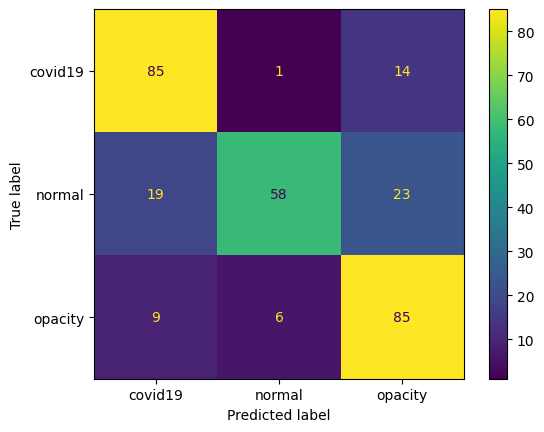

In [61]:
cm = confusion_matrix(
    y_list,
    y_hat_list,
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])
     